# GMM and EM
Gaussian Mixture Models and Expectation Maximization  

See the GMM section in our notebook on clustering.

Here we show canned and homgrown implementations.

## Using a library call
Follow tutorial in [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class GaussianMixture.

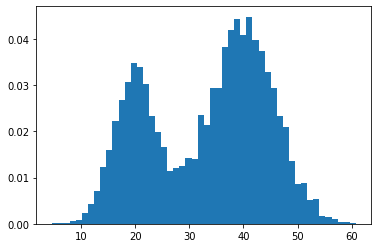

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=4, size=3000) 
X2 = normal(loc=40, scale=6, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [40.12393482] wgt= 0.6558554720723032 Cov= 35.18031223938772
Gaussian 1 mean= [20.2403304] wgt= 0.34414452792769873 Cov= 17.911323759348424


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 1
Predicted class of a point on the right: 0


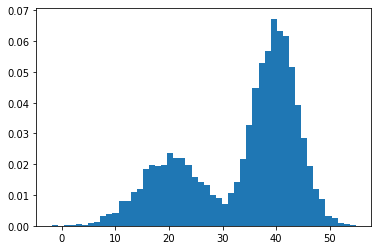

In [5]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=4, size=3000) 
G1 = normal(loc=mean1, scale=6, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=4, size=6000) 
    G1 = normal(loc=mean1, scale=6, size=3000)
plot(G0,G1)

## Homegrown version
Assumption: the observed data was generated by n Gaussian processes.

The maximum likelihood estimate can be appoximated by exepctation maximization with one caveat: there are singularities in the search space
where mean = some data point, variance is zero, and likelihood is infinite.

See Bishop, Pattern Recognition, section 9.2, starting on page 430.
See [YouTube](https://youtu.be/iQoXFmbXRJA) video by Victor Lavrenko.

The model includes a vector of Gaussians.
Each Gaussian is characterized by a mean and standard deviation
(or mean and covariance matrix for higher dimensional points).
The model also includes a mixing parameter $\pi$.
This ia a vector holding the probability of drawing from each Gaussian.
The mixture model says point x has probability equal to weigthed sum of Gaussians:    
$p(x) = \sum_i \pi_i \mathcal{N}(x|\mu_i,\sigma_i)$
We wish to compute $\pi, \mu, \sigma$

Bishop introduces a latent, unknown variable 
z = a 1-of-K bit vector indicting which Gaussian was responsible for x.
This doesn't change anything but it allows him to deal with
conditional probabilities p(z|x) rather than marginal probabilities p(x).
Then he derives likelihood formulas for mean and stdev. 
These formulae involve the conditionals as weights on the deviations.

Our code tackles an easy case.
Easy case: num features per data point = 1. This avoids matricies & covariance.
Easy case: num gaussians = 2. This avoids loops through all gaussians.

In [6]:
import scipy.stats as ss
import numpy as np
def responsibility(mean,stdev,data):
    # Probability of each datapoint under the given Gaussian parameters.
    L=np.asarray([ss.norm.pdf(x,loc=mean,scale=stdev) for x in data])
    return L
def conditional_probabilities(like1,like2): 
    # get conditional probability of each model given these likelihoods
    length = len(like1)
    cond1=np.zeros(length)
    cond2=np.zeros(length)
    # TO DO: use vectors instead of for loop 
    for i in range(length):      
        # This formula is same as Bayes rule 
        # if we multiply both likelihoods by prior=50%
        prob_of_data = like1[i]+like2[i]
        cond1[i] = like1[i] / prob_of_data  
        cond2[i] = like2[i] / prob_of_data  
    return cond1,cond2
def mle_mean(weights,data):
    length = len(data)
    weighted = data*weights  # Hadamard vector multiply
    mean=sum(weighted)/sum(weights)
    return mean
def mle_stdev(mean,weights,data):
    # sum of the squares of the weighted deviations from the mean
    dev = data-mean
    wdev = dev*weights
    sse = sum(wdev**2)
    stdev=float(np.sqrt(sse/sum(weights)))
    return stdev
def show(stage,mean1,stdev1,mean2,stdev2,mix,lnp):
    mixing = "{}/{}".format(int(100*mix),int(100*(1-mix)))
    print('%s: %f +/- %d, %f +/- %d, Mix=%s LL=%d'%
          (stage,mean1,stdev1,mean2,stdev2,mixing,lnp))
def log_likelihood(data,mean1,mean2,stdev1,stdev2,mix1):
    mix2 = 1-mix1
    sum_of_logs = 0
    for x in data:
        sum  = mix1 * ss.norm.pdf(x,loc=mean1,scale=stdev1)
        sum += mix2 * ss.norm.pdf(x,loc=mean2,scale=stdev2)
        sum_of_logs += np.log2(sum)
    return sum_of_logs
def expectation_maximization(data,num_iter):
    # 1. Initial step.
    # These initial guesses are arbitrary but ok being based on the overall data.
    mean=np.mean(data)
    stdev=np.std(data)
    mean1 = mean-0.5
    mean2 = mean+0.5
    stdev1 = stdev
    stdev2 = stdev
    mix = .5
    lnp=0
    show('Initial',mean1,stdev1,mean2,stdev2,mix,lnp)
    for i in range(num_iter):
        # 2. E-step. Evaluate responsibilities.
        # Get conditional prob of each point assuming either Gaussian model.
        resp1 = responsibility(mean1,stdev1,data)
        resp2 = responsibility(mean2,stdev2,data)
        cond1,cond2 = conditional_probabilities(resp1,resp2)
        # 3. M-step. Re-estimate model parameters by weighted MLE.
        mean1 = mle_mean(cond1,data)
        mean2 = mle_mean(cond2,data)
        stdev1 = mle_stdev(mean1,cond1,data)
        stdev2 = mle_stdev(mean2,cond2,data)
        # re-compute the mixing parameter
        mix = np.sum(cond1)/np.sum(cond1+cond2)
        # 4. Terminate if log likelihood is no longer changing.
        # As shortcut, we just fix the number of iterations.
        lnp = log_likelihood(data,mean1,mean2,stdev1,stdev2,mix)
        show('Intermediate',mean1,stdev1,mean2,stdev2,mix,lnp)
    print()
    show('Final',mean1,stdev1,mean2,stdev2,mix,lnp)
    return mean1,mean2,stdev1,stdev2

In [7]:
X1 = normal(loc=20, scale=4, size=3000) 
X2 = normal(loc=40, scale=6, size=6000)
X = hstack( (X1, X2) ) 
X = np.asarray(X)
mean1,mean2,stdev1,stdev2=expectation_maximization(X,20)

Initial: 32.793120 +/- 10, 33.793120 +/- 10, Mix=50/50 LL=0
Intermediate: 32.793790 +/- 7, 33.792443 +/- 7, Mix=49/50 LL=-51441
Intermediate: 32.248931 +/- 8, 34.360938 +/- 7, Mix=50/49 LL=-51351
Intermediate: 31.099881 +/- 8, 35.692282 +/- 6, Mix=52/47 LL=-50905
Intermediate: 29.296218 +/- 9, 38.205415 +/- 4, Mix=55/44 LL=-49801
Intermediate: 27.822980 +/- 9, 40.203137 +/- 3, Mix=55/44 LL=-49292
Intermediate: 27.100460 +/- 8, 41.102999 +/- 3, Mix=55/44 LL=-49282
Intermediate: 26.606303 +/- 8, 41.656709 +/- 3, Mix=55/44 LL=-49210
Intermediate: 25.950829 +/- 7, 42.038169 +/- 3, Mix=54/45 LL=-49019
Intermediate: 25.013745 +/- 6, 42.250819 +/- 4, Mix=51/48 LL=-48716
Intermediate: 24.003482 +/- 6, 42.076109 +/- 4, Mix=48/51 LL=-48445
Intermediate: 23.157420 +/- 5, 41.723345 +/- 4, Mix=45/54 LL=-48238
Intermediate: 22.432452 +/- 5, 41.420224 +/- 4, Mix=42/57 LL=-48049
Intermediate: 21.829400 +/- 4, 41.158976 +/- 4, Mix=40/59 LL=-47887
Intermediate: 21.351121 +/- 4, 40.940102 +/- 5, Mix=39/6

## Explanation
Assume every point was generated by process 0 or process 1.
Assume processes 0 and 1 are Gaussian. 
Each process has a mean and stdev.
These are the parameters of the generating model.
These are unknowns that we'll estimate.
Start by guessing the number of processes, and the mean and stdev of each.

EM loops over two steps.  
* E-Step: The word expectation is not helpul. For every point, assign responsibility to each process. For K-means, assign 0 for one and 1 for the other i.e. all-or-nothing. For GMM, assign probabilities that sum to one across all processes.  
* M-Step: Re-estimate the mean and stdev of each process. Use maximum likelihood to choose parameters that maximize the likelihood of this data. When computing the new mean and stdev, weight the sums by the assigned responsibilities. 